Date: 19.05.2023 \
Author: Reto Hendry

This scripts is used to find out the feature importance of the best performing models on the parameter set which is best for all models.

The best parameters are resample cube 3 and number of features 70. This can be seen in the script "etric_analysis_autoML_tools.ipynb"

In [33]:
import numpy as np
import pandas as pd
import os
import sys
from matplotlib import pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, precision_score
from pycaret.classification import (
    setup, compare_models, tune_model, save_model, plot_model,
    predict_model, get_metrics, pull, evaluate_model, load_model)

os.environ['PYDEVD_WARN_EVALUATION_TIMEOUT'] = '10.0'
os.environ['PYDEVD_UNBLOCK_THREADS_TIMEOUT'] = '5.0'

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from functions.function_get_feature_positions import get_feature_positions
from functions.function_export_feature_positions import export_feature_positions
from functions.function_get_label_df import get_label_df
from functions.function_get_component_array import get_component_array
from functions.function_get_best_features import get_best_features_sorted
from functions.function_resample_4d_array import resample_4d_array

## prepare data

In [34]:
# parameters to define
component = [1]
resample_cube = 3
number_of_features = 70

##############################################

# get the label data
df_label = get_label_df(data_path_optional="../../data/")

# get the MVPA data arrays
component_array_5d = get_component_array(component, data_path_optional="../../data/")
print(f"shape of component_array_5d: {component_array_5d.shape}")

sample_array_4d = resample_4d_array(component_array_5d[0], resample_cube)
print(f"shape of resampled sample_array_4d: {sample_array_4d.shape}")

# get the sorted feature list
best_feature_list = get_best_features_sorted(
    sample_array_4d, df_label
)

# select desired number of features
best_features = best_feature_list[:number_of_features]

shape of component_array_5d: (1, 90, 91, 109, 91)
Resampling in progress...


100%|██████████| 90/90 [00:00<00:00, 148.99it/s]


shape of resampled sample_array_4d: (90, 31, 37, 31)
Calculating list of best features ...


100%|██████████| 35556/35556 [01:01<00:00, 581.04it/s]


In [35]:
# Define the cross-validation strategy
cv_stratified = StratifiedKFold(n_splits=9, shuffle=True, random_state=42)

# reshape 4d array to dataframe
sample_df = pd.DataFrame(
    sample_array_4d.reshape(sample_array_4d.shape[0], -1)
).iloc[:, best_features]

# Combine sample_df and df_label
data = pd.concat([sample_df, df_label["Cond"]], axis=1)

# split data into train and test
train_data, test_data = train_test_split(
    data,
    test_size=0.2,
    random_state=42,
    stratify=data["Cond"]
)


## load model

In [36]:
# load the model
model_path = "../param_sweep_best_models/pycaret_best_models/pycaret_20230519_074403"
saved_model = load_model(model_path)

predictions = predict_model(saved_model, data = test_data)

Transformation Pipeline and Model Successfully Loaded


In [37]:
saved_model

Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['17926', '17895', '16779', '13181',
                                             '15786', '14328', '15444', '17706',
                                             '22357', '20437', '14358', '16591',
                                             '13127', '14359', '11979', '18018',
                                             '13928', '6424', '13212', '15351',
                                             '22356', '18852', '23504', '9720',
                                             '15505', '17738', '15413', '13211',
                                             '11105', '12781', ...],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('normalize', TransformerWrapper(transformer=StandardScaler())),
                ('trained_model',
                 RandomForestClassifier(n_jobs=-1, random_state=1))])

In [38]:
np.array(predictions.loc[:, "prediction_label"])

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0])

In [39]:
np.array(test_data.loc[:, "Cond"])

array([1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0])

In [40]:
# Calculate the accuracy and F1 score on the test set
test_accuracy = accuracy_score(
    test_data["Cond"], predictions["prediction_label"]
)
test_f1_score = f1_score(
    test_data["Cond"], predictions["prediction_label"], average="weighted"
)
test_precision_score = precision_score(
    test_data["Cond"], predictions["prediction_label"], average="weighted"
)

In [41]:
# print all the results
print(f"test_accuracy: {test_accuracy}")
print(f"test_f1_score: {test_f1_score}")
print(f"test_precision_score: {test_precision_score}")

test_accuracy: 0.8333333333333334
test_f1_score: 0.8328173374613004
test_precision_score: 0.8374999999999999


## get feature importance

In [42]:
# assuming features is a list of feature names
features = sample_df.columns

# get feature importances from the model
importances = saved_model.feature_importances_

# create a dataframe
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Relative_Importance': importances
})

# Calculate the maximum of Relative Importance
max_importance = feature_importance_df['Relative_Importance'].max()

# Calculate the sum of Relative Importance
sum_importance = feature_importance_df['Relative_Importance'].sum()

# Add Scaled Importance to the dataframe
feature_importance_df['Scaled_Importance'] = feature_importance_df['Relative_Importance'] / max_importance

# Add Percentage to the dataframe
feature_importance_df['Percentage'] = feature_importance_df['Relative_Importance'] / sum_importance

feature_importance_df = (feature_importance_df.sort_values(by=['Scaled_Importance'], ascending=True)
                        .set_index('Feature'))

# display the dataframe
print(feature_importance_df)

         Relative_Importance  Scaled_Importance  Percentage
Feature                                                    
18792               0.002882           0.060293    0.002882
22356               0.002998           0.062726    0.002998
18756               0.003271           0.068438    0.003271
17987               0.003455           0.072295    0.003455
19227               0.004711           0.098569    0.004711
...                      ...                ...         ...
11105               0.027271           0.570562    0.027271
16779               0.029020           0.607148    0.029020
6424                0.035107           0.734513    0.035107
13181               0.037613           0.786935    0.037613
9689                0.047797           1.000000    0.047797

[70 rows x 3 columns]


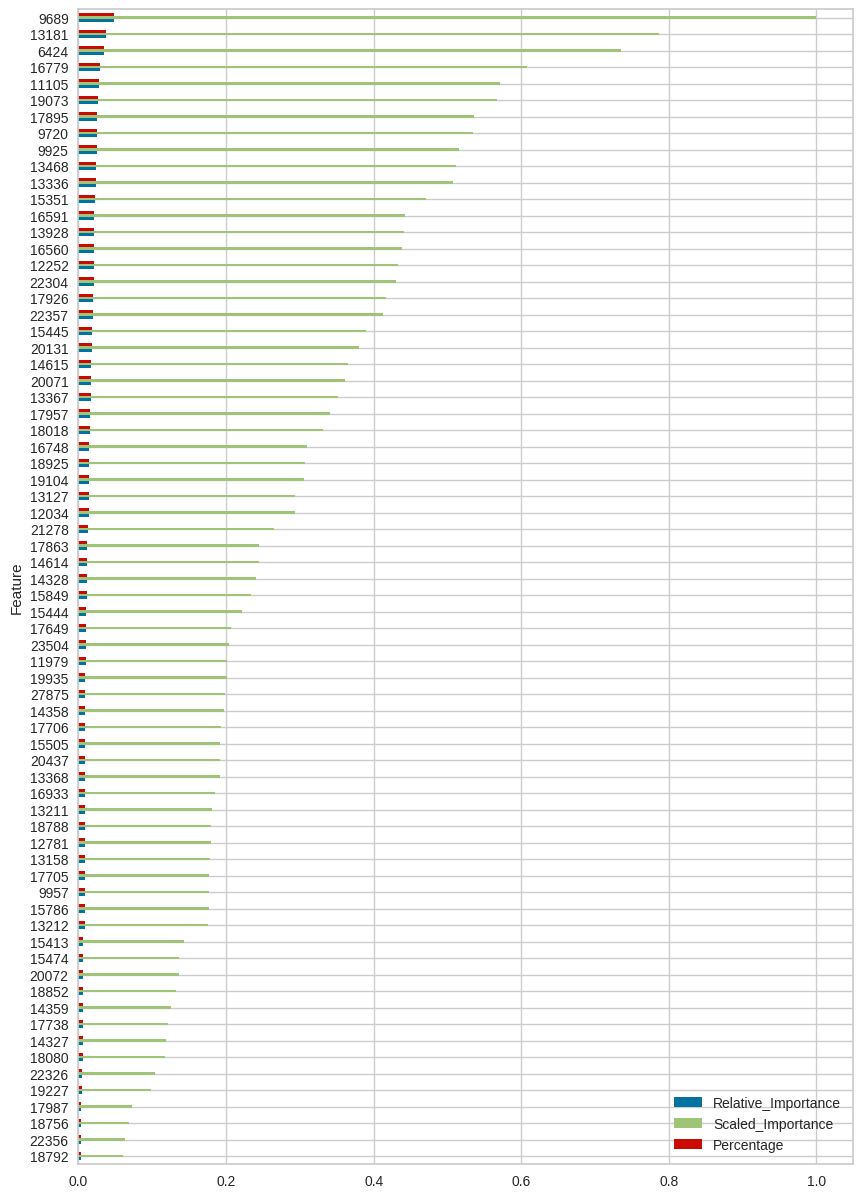

In [43]:
feature_importance_df.plot(kind='barh', figsize=(10, 15))
plt.show()

In [44]:
# export to a csv file
feature_importance_df.to_csv("feature_importance_pycaret.csv")

## Export to NIfTI with feature importance

In [45]:
feature_importance_df.sort_values(by=['Scaled_Importance'], ascending=False)

,Relative_Importance,Scaled_Importance,Percentage
Feature,,,
9689,0.047797,1.000000,0.047797
13181,0.037613,0.786935,0.037613
6424,0.035107,0.734513,0.035107
16779,0.029020,0.607148,0.029020
11105,0.027271,0.570562,0.027271
...,...,...,...
19227,0.004711,0.098569,0.004711
17987,0.003455,0.072295,0.003455
18756,0.003271,0.068438,0.003271


In [46]:
index_descending = list(feature_importance_df.sort_values(by=['Scaled_Importance'], ascending=False).index)
print(type(index_descending))
print(index_descending)

importance_descending = list(feature_importance_df.sort_values(by=['Scaled_Importance'], ascending=False).loc[:, "Scaled_Importance"])
print(type(importance_descending))
print(importance_descending)

<class 'list'>
[9689, 13181, 6424, 16779, 11105, 19073, 17895, 9720, 9925, 13468, 13336, 15351, 16591, 13928, 16560, 12252, 22304, 17926, 22357, 15445, 20131, 14615, 20071, 13367, 17957, 18018, 16748, 18925, 19104, 13127, 12034, 21278, 17863, 14614, 14328, 15849, 15444, 17649, 23504, 11979, 19935, 27875, 14358, 17706, 15505, 20437, 13368, 16933, 13211, 18788, 12781, 13158, 17705, 9957, 15786, 13212, 15413, 15474, 20072, 18852, 14359, 17738, 14327, 18080, 22326, 19227, 17987, 18756, 22356, 18792]
<class 'list'>
[1.0, 0.7869347209854332, 0.7345133855217667, 0.6071480451276842, 0.5705621213664693, 0.5669316388524708, 0.5363418331829566, 0.5349346691029763, 0.5158714951643866, 0.5112950759622692, 0.5070690863979845, 0.4711269320025272, 0.44285953796980204, 0.4415239474726077, 0.4388664917035187, 0.4325289931812397, 0.42975825724193134, 0.41631392769236, 0.41323318046499774, 0.3890166298983627, 0.3794995469760098, 0.36574469017872, 0.361210049963664, 0.3513392314429304, 0.34103106391137483,

In [47]:
component = 1
resample_cube = 3
number_of_features = 70
padding = [(1, 1), (1, 1), (1, 1)]
shape_resampled_array = (90, 31, 37, 31)
best_features = index_descending

# create the marker array
marker, marker_array_shape = get_feature_positions(
    top_features=best_features,
    padding=padding,
    resample_cube=resample_cube,
    shape_resampled_array=shape_resampled_array[-3:],
)

# export the feature positions to a NIfTI file
component = component
reshape_cube = resample_cube
number_of_features = number_of_features
output_path = "../NIfTY_feature_masks"
export_feature_positions(
    array_shape=marker_array_shape, 
    marker=marker, 
    output_path=output_path,
    output_filename=f"feature_importance_pycaret_{reshape_cube}_{number_of_features}",
    feature_importance=importance_descending
)


done with get_feature_positions
saved feature_importance_pycaret_3_70.nii successfully
